# Import all essential libraries

In [1]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Initialize and Authenticate Earth Engine

In [2]:
ee.Initialize()
ee.Authenticate()

True

# Add Webmap

In [3]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Import shapefile which is uploaded on Google Earth Engine Assets

In [4]:
shp = ee.FeatureCollection("projects/ee-gistg001/assets/Sample")
Map.addLayer(shp,{}, 'Boundary', True)
Map.setCenter(shp)

# Define Start date & End date to select images for analysis in interested time period.

In [5]:
START_DATE =('2023-01-01')
END_DATE = ('2023-12-31')

# Select bands to calculate NDVI

In [6]:
def addnd(input):
    nd = input.normalizedDifference(['B8', 'B4']).rename('ndvi')
    return input.addBands(nd)

# Select bands to calculate EVI

In [7]:
def addev(input):
    NIR = input.select('B8')  # Near-Infrared band
    RED = input.select('B4')  # Red band
    BLUE = input.select('B2') # Blue band
    
    # Define coefficients
    G = 2.5
    C1 = 6
    C2 = 7.5
    L = 1.0
    
    # Calculate EVI
    evi = input.expression(
        'G * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE) + L)', {
            'NIR': NIR,
            'RED': RED,
            'BLUE': BLUE,
            'G': G,
            'C1': C1,
            'C2': C2,
            'L': L
        }).rename('evi')
    
    return input.addBands(evi)


# Select Image Collection and define the cloud cover percentage

In [8]:
dataset = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(shp) \
    .filterDate(START_DATE, END_DATE) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 10) \
    .map(addnd)\
    .map(addev)\

num_images = dataset.size().getInfo()
print(num_images)

36


# Select NDVI to add in Webmap

In [9]:
ndvi = dataset.select('ndvi').filterBounds(shp)
Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['red','yellow','green']}, 'NDVI S2', True)

# Select EVI to add in Webmap

In [10]:
evi = dataset.select('evi').filterBounds(shp)
Map.addLayer(evi, {'min': -1, 'max': 1, 'palette': ['white','blue','cyan','yellow','green']}, 'EVI S2', True)

# Add Time series NDVI

In [11]:
ts = ndvi.toBands()
Map.addLayer(ts, {}, "NDVI Time series", False)

# Define the output directory to save the data

In [12]:
import os
out_dir = os.path.expanduser(r"D:\Sample")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Join the path and output name

In [13]:
import pandas as pd
ndvi_stats = os.path.join(out_dir, 'ndvi_time_series.csv')
evi_stats = os.path.join(out_dir, 'evi_time_series.csv')

# Saving the output at defined location

In [14]:
geemap.zonal_statistics(ndvi, shp, statistics_type='MEAN', scale=10)
geemap.zonal_statistics(evi, shp, statistics_type='MEAN', scale=10)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\Sample\ndvi_time_series.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\Sample\evi_time_series.csv


# Read the downloaded NDVI csv file 

In [15]:
df = pd.read_csv(r"D:\Sample\ndvi_time_series.csv", header=None).T
df.columns = ['Date', 'Ndvi_value']
df = df[df['Date'].str.contains('ndvi', case=False)]
df['Date'] = df['Date'].str.split('T').str[0]
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Ndvi_value'] = pd.to_numeric(df['Ndvi_value'], errors='coerce')  
df.dropna(subset=['Ndvi_value'], inplace=True)  
df = df.sort_values(by='Date')
df.to_csv(r"D:\Sample\output_ndvi_data.csv", index=True) # Below It will be used as input for Machine Learning

# Plotting NDVI time series data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


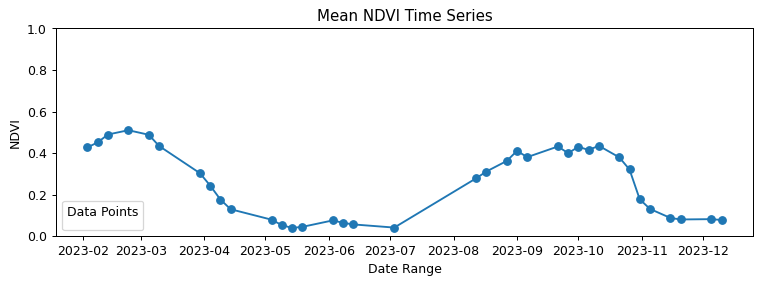

In [16]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=90)
ax.plot(df['Date'], df['Ndvi_value'], marker='o')
ax.set_title("Mean NDVI Time Series")
ax.set_ylabel("NDVI")
ax.set_ylim([0, 1])
ax.set_xlabel("Date Range")
ax.legend(title="Data Points", loc="lower left", ncol=2)
plt.show()

# Read the downloaded EVI csv file

In [17]:
df1 = pd.read_csv(r"D:\Sample\evi_time_series.csv", header=None).T
df1.columns = ['Date', 'evi_value']
df1 = df1[df1['Date'].str.contains('evi', case=False)]
df1['Date'] = df1['Date'].str.split('T').str[0]
df1 = df1.reset_index(drop=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1['evi_value'] = pd.to_numeric(df1['evi_value'], errors='coerce')  
df1.dropna(subset=['evi_value'], inplace=True)  
df1 = df1.sort_values(by='Date')


# Plotting EVI time series data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


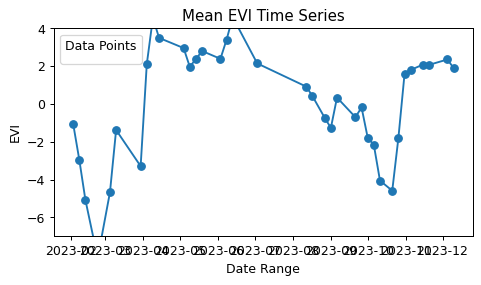

In [18]:
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=90)
ax1.plot(df1['Date'], df1['evi_value'], marker='o')
ax1.set_title("Mean EVI Time Series")
ax1.set_ylabel("EVI")
ax1.set_ylim([-7, 4])
ax1.set_xlabel("Date Range")
ax1.legend(title="Data Points", loc="upper left", ncol=2)
plt.show()